<a href="https://colab.research.google.com/github/BhargavKondepudi26/pt1/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING ALL THE REQUIRED LIBRARIES**

In [7]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 15
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
import datetime
import quandl

# **GETTING THE CRUDE PRICE DATA**# 

In [9]:
mydata = quandl.get("FRED/DCOILWTICO", trim_start="2012-10-20", trim_end="2022-10-19",  authtoken="JvvFdXyoMVKhCixW4_WA")
mydata.to_csv("crudeprice.csv")

# **Reading data to a dataframe with dates as a index**# 

In [10]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('crudeprice.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse, infer_datetime_format=True)
ts = data['Value']
print (data.head())

            Value
Date             
2012-10-22  88.30
2012-10-23  86.65
2012-10-24  85.39
2012-10-25  85.59
2012-10-26  85.84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=5).mean()
    rolstd = pd.Series(timeseries).rolling(window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

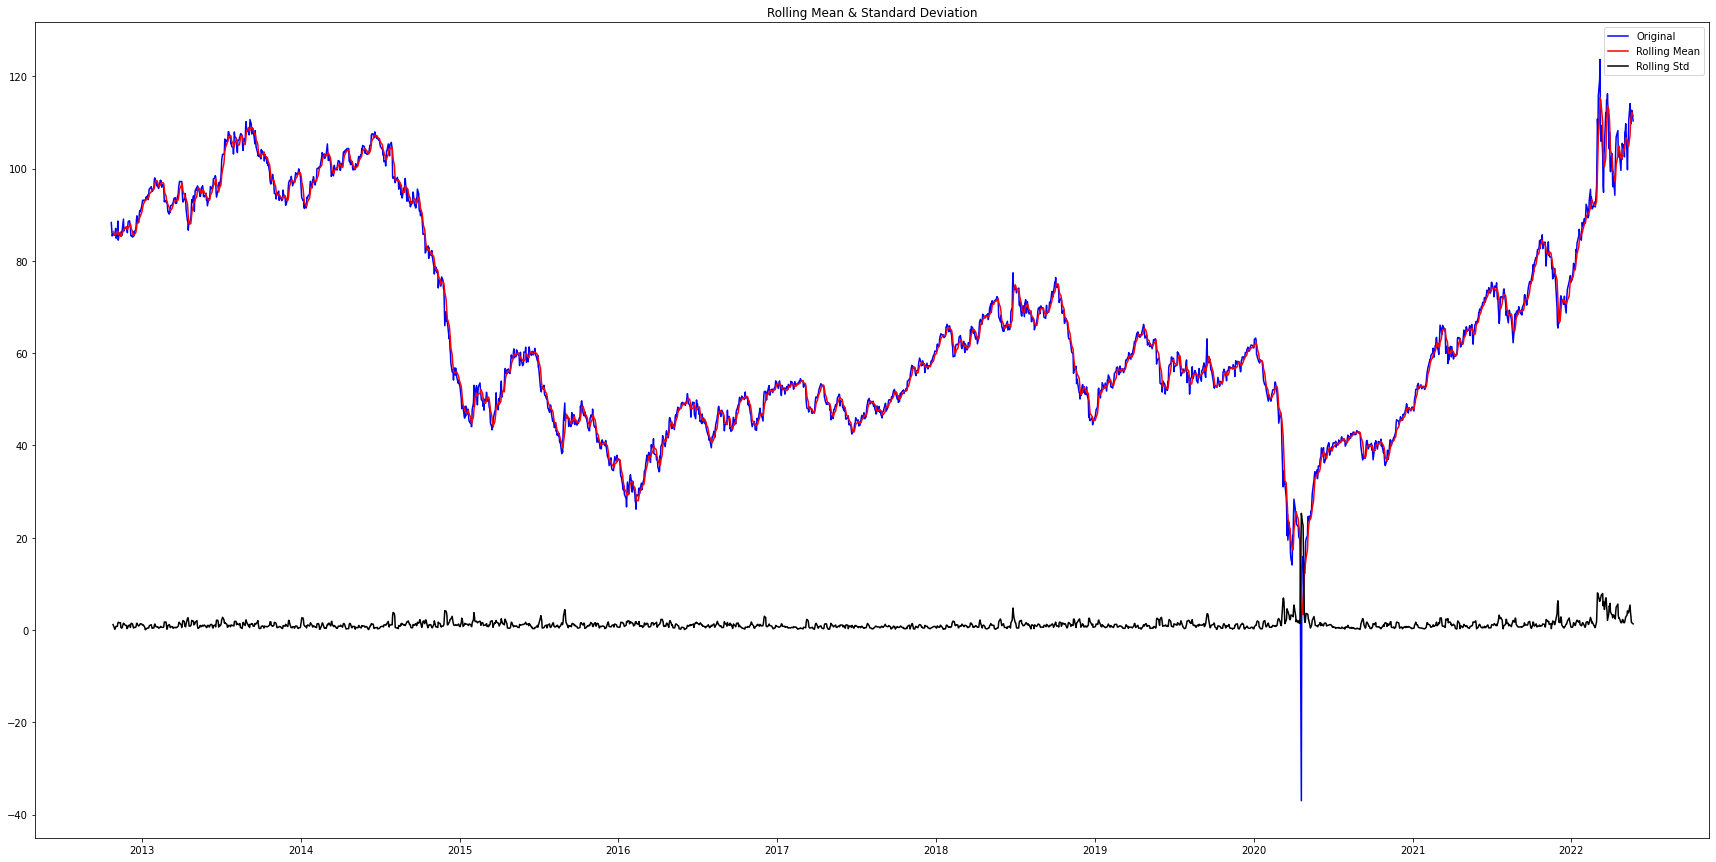

Results of Dickey-Fuller Test:
Test Statistic                   -1.370042
p-value                           0.596551
#Lags Used                       22.000000
Number of Observations Used    2384.000000
Critical Value (1%)              -3.433096
Critical Value (5%)              -2.862753
Critical Value (10%)             -2.567416
dtype: float64


In [14]:
test_stationarity(ts)

## **Removing Seasonality**

In [15]:
ts_log = np.log(ts)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
ts_log_diff = ts_log - ts_log.shift()

In [17]:
ts_log_diff.dropna(inplace=True)

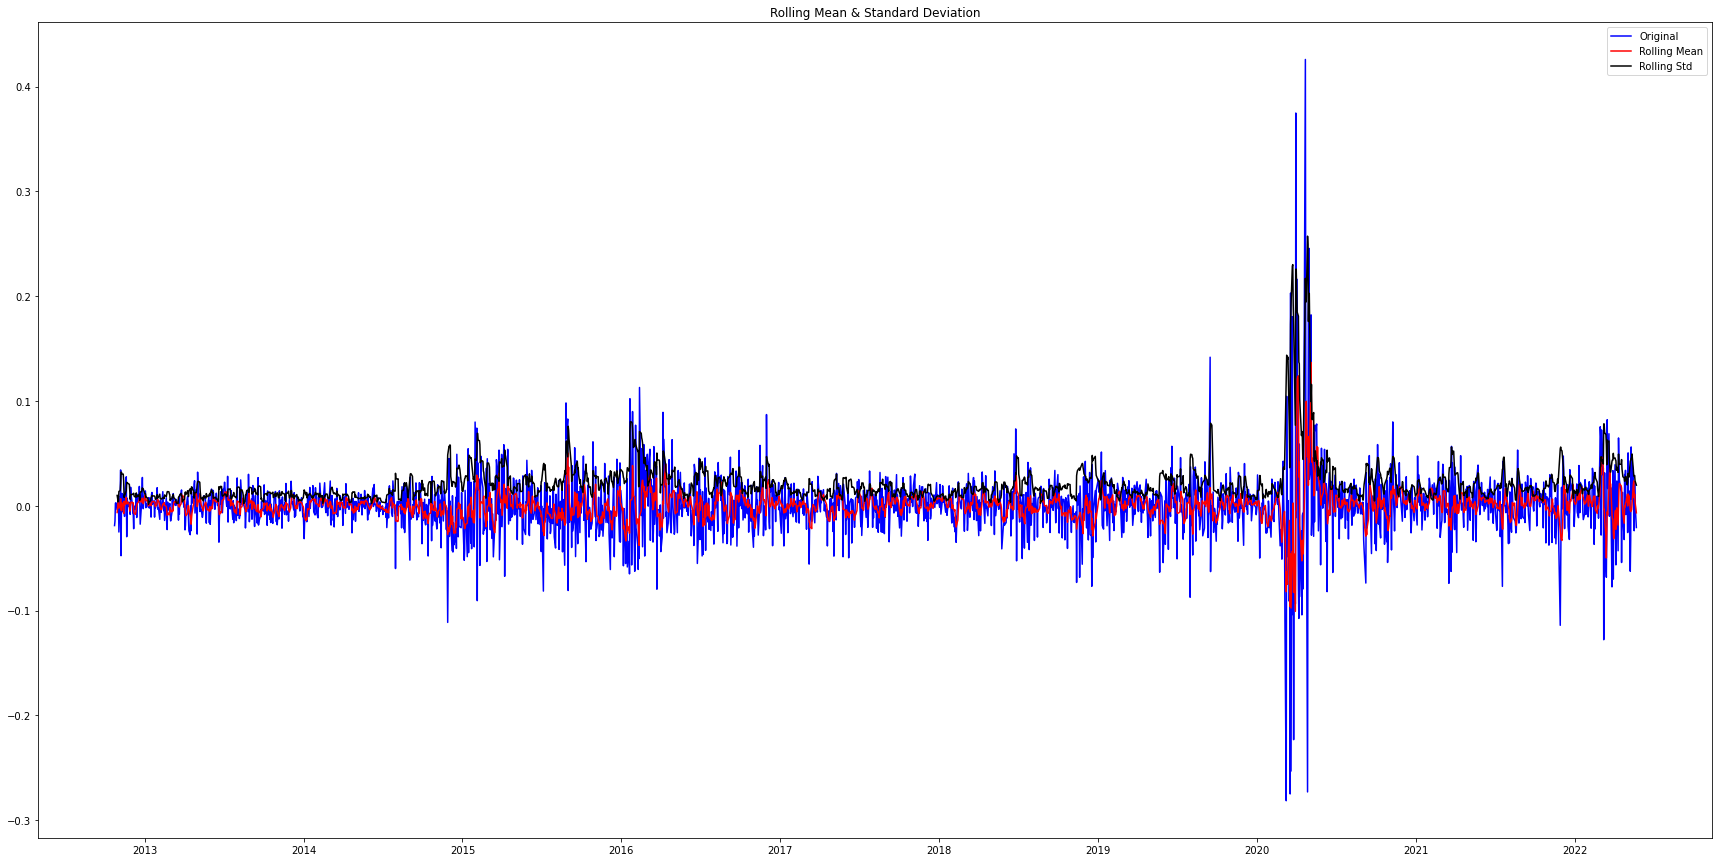

Results of Dickey-Fuller Test:
Test Statistic                -8.666826e+00
p-value                        4.660042e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.376000e+03
Critical Value (1%)           -3.433105e+00
Critical Value (5%)           -2.862757e+00
Critical Value (10%)          -2.567418e+00
dtype: float64


In [18]:
test_stationarity(ts_log_diff)

## **Deciding parameters for ARIMA(p,d,q) Model**

In [19]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [20]:
import statsmodels.api as sm

Text(0.5, 1.0, 'Autocorrelation Function')

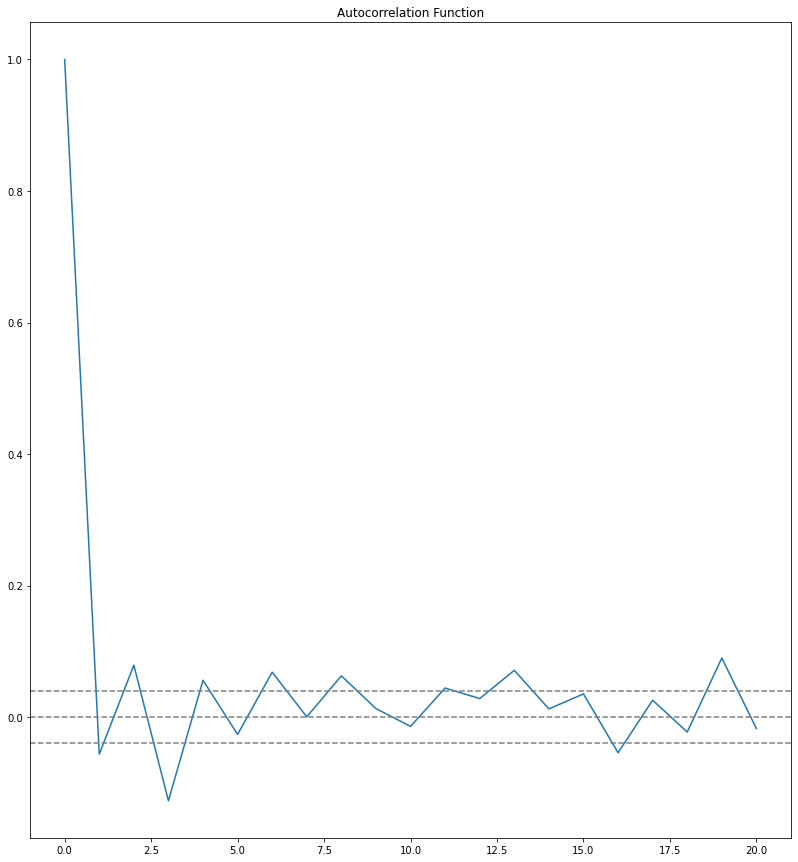

In [21]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

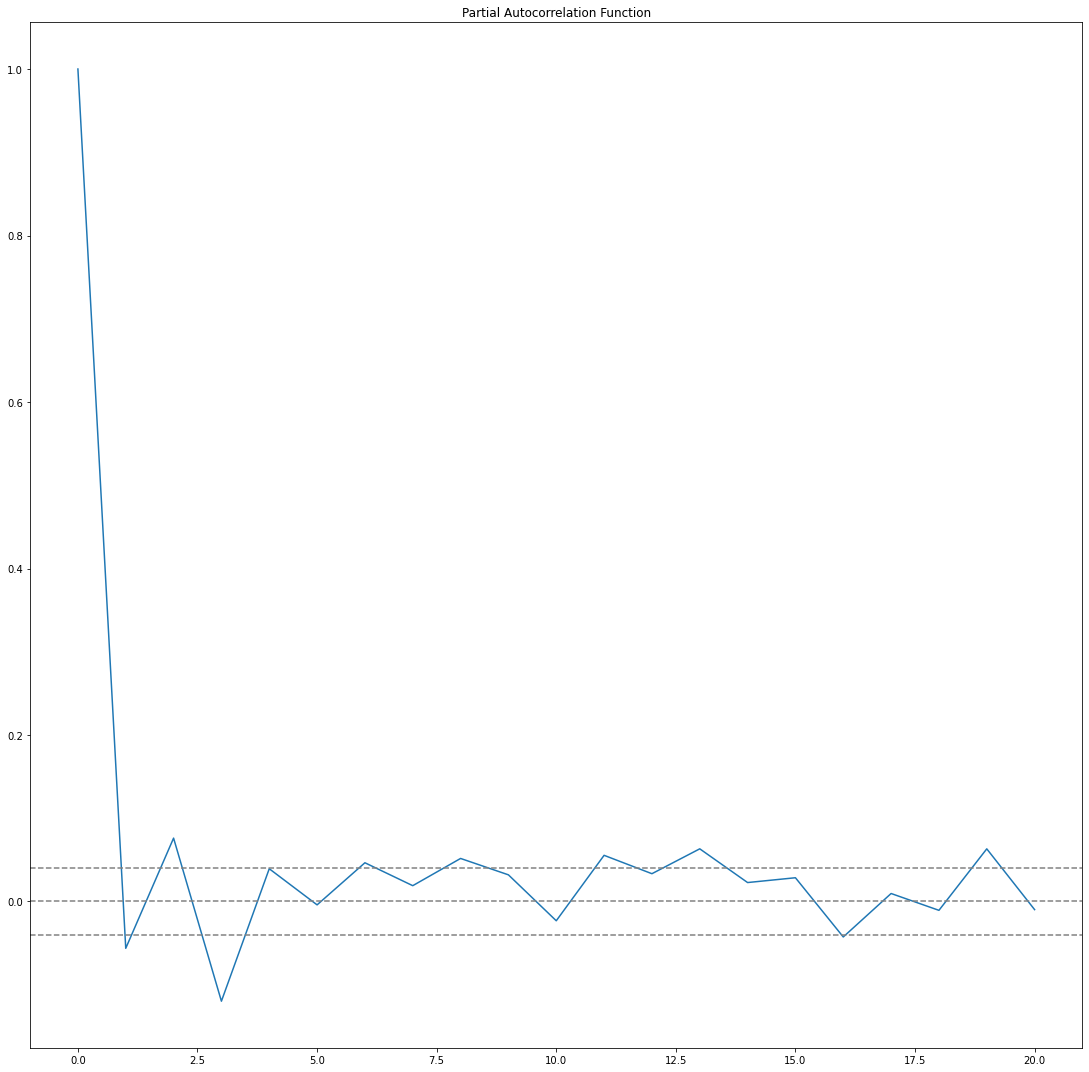

In [22]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## **Predicting the last value in the data**

In [23]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Expected: 110.320
Forecast: 112.360
Standard Error: 2.013
95% Confidence Interval: 108.414 to 116.305


In [24]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 112.360 between 109.780 and 114.939
90.0% Confidence Interval: 112.360 between 109.048 and 115.671
95.0% Confidence Interval: 112.360 between 108.414 and 116.305
99.0% Confidence Interval: 112.360 between 107.174 and 117.545


## **Predictions for the next 5 days**

In [25]:
X = ts.values
last_date = data.index[-1] + datetime.timedelta(days=1)
window = 5
model = ARIMA(X, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast(alpha=0.01)
X = np.append(X, forecast)
predictions = {}
print('Expected: %.3f' % X[-1])
print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

for t in range(window):
    last_date = last_date + datetime.timedelta(days=1)
    model = ARIMA(X, order=(2,1,2))
    model_fit = model.fit(disp=False)
    forecast, stderr, conf = model_fit.forecast(alpha=0.01)
    X = np.append(X, forecast)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
    predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

Expected: 110.832
99.0% Confidence Interval: 110.832 between 105.647 and 116.017
99.0% Confidence Interval: 110.869 between 105.685 and 116.053
99.0% Confidence Interval: 110.939 between 105.756 and 116.122
99.0% Confidence Interval: 110.905 between 105.723 and 116.087
99.0% Confidence Interval: 110.959 between 105.778 and 116.140
99.0% Confidence Interval: 110.926 between 105.746 and 116.106


In [26]:
predictions

{'2022-05-24': (105.64683080848067, 116.0171442760697, 110.83198754227519),
 '2022-05-25': (105.68461116328254, 116.05277020922907, 110.8686906862558),
 '2022-05-26': (105.7559552124012, 116.12196117491263, 110.93895819365692),
 '2022-05-27': (105.72297599092707, 116.08683021534927, 110.90490310313817),
 '2022-05-28': (105.77830621006792, 116.14001003452053, 110.95915812229423),
 '2022-05-29': (105.74647522656261, 116.1060299873644, 110.9262526069635)}